In [56]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_rs_df, load_ver_df

# Load data


In [57]:
RS_PATH = "../data/evaluation/random_search"

rs_df = load_rs_df(RS_PATH)
rs_df = rs_df.reset_index().set_index(
    ['fps', 'highquality', 'rep', 'it', 'route_id'])


scenario_df = load_scenario_df("../data/definition/rs_routes.xml")

rs_df = rs_df.join(scenario_df, on='route_index', how='inner').sort_index()

# verification set is becoming a
ver_df = load_ver_df(RS_PATH + "/rs_v3/verification").set_index(
    'route_id')

## Load model


In [58]:

with open("model.pkl", "rb") as f:
    model = pickle.load(f)

# Predict fidelity robustness


In [59]:
def make_mff_fusion(rs_df, ver_df):
    pass

In [60]:


# Do it just for 10FPS epic
rs_df = rs_df.xs(("10", "True"), drop_level=False).sort_index()

model_features = ['max_angles', 'dist_len_ratio', 'n_turns']
X = rs_df[model_features].to_numpy()
X.shape
rs_df['predicted_class'] = model.predict(X)
rs_df = rs_df[['driving_score', 'duration_system', 'predicted_class']]
rs_df['predicted_class'].value_counts()

predicted_class
risky    686
safe      64
Name: count, dtype: int64

**! very important here**
Here in 10FPS epic we have deemed 64 safe runs so they will be using low fid.
The rest of risky scenarios (686) will use high fidelity


to substitute running for risky scenario swap with 20Fid executions which is in verification set


In [61]:

processed_batches = []
for label, batch in rs_df.groupby('predicted_class'):
    match label:
        case 'safe':
            # do nothihg if scenario is safe to run
            batch['swapped'] = 'no'
            pass
        case 'risky':

            # use verification data set as high fidelity
            high_fid = ver_df
            # if scenario is risky swap with HF data from verification set
            high_fid = high_fid[['driving_score', 'duration_system']]
            batch = batch.drop(['driving_score', 'duration_system'], axis=1)
            batch = batch.join(high_fid, on='route_id')
            batch['swapped'] = 'yes'

    processed_batches.append(batch)

rs_df = pd.concat(processed_batches).sort_index()
rs_df

predicted_class  driving_score  \
fps highquality rep it route_id                                           
10  True        0   0  RouteScenario_88            risky       0.984344   
                    1  RouteScenario_744           risky       1.000000   
                    2  RouteScenario_718           risky       1.000000   
                    3  RouteScenario_317           risky       0.941897   
                    4  RouteScenario_611           risky       1.000000   
...                                                  ...            ...   
                29  20 RouteScenario_696           risky       1.000000   
                    21 RouteScenario_544           risky       0.161731   
                    22 RouteScenario_451           risky       1.000000   
                    23 RouteScenario_14            risky       1.000000   
                    24 RouteScenario_658           risky       1.000000   

                                          duration_system swapped  
fps highquality rep it route_id                                    
10  True        0   0  RouteScenario_88        840.896933     yes  
                    1  RouteScenario_744       351.942358     yes  
                    2  RouteScenario_718       295.314870     yes  
                    3  RouteScenario_317      1938.618472     yes  
                    4  RouteScenario_611       426.810451     yes  
...                                                   ...     ...  
                29  20 RouteScenario_696       404.275449     yes  
                    21 RouteScenario_544       662.798116     yes  
                    22 RouteScenario_451       447.011473     yes  
                    23 RouteScenario_14        468.577047     yes  
                    24 RouteScenario_658       363.801308     yes  

[750 rows x 4 columns]

## Compute solutions


In [62]:

def get_solutions_of_iteration(df, curr_it):

    idx = pd.IndexSlice
    # get slice of data frame from iteration 0 to current iteration
    slice = df.loc[idx[:, :, :, :curr_it+1], :]

    # get index of minumum driving score -> solution (in iterations so far)
    gb = slice.groupby(['fps', 'highquality', 'rep',])[
        'driving_score']

    solutions_idx = gb.idxmin().rename('solution_idx')

    # get value of minimum driving score
    solutions_score = gb.min().rename('solution_score')

    solutions = pd.concat([solutions_idx, solutions_score], axis=1)
    solutions['it'] = curr_it
    solutions = solutions.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it'])

    return solutions

In [63]:
oracle_df = ver_df['driving_score'].rename("oracle_dscore")
oracle_df

route_id
RouteScenario_0      0.65
RouteScenario_1      0.65
RouteScenario_2      1.00
RouteScenario_3      1.00
RouteScenario_4      1.00
                     ... 
RouteScenario_743    1.00
RouteScenario_744    1.00
RouteScenario_745    1.00
RouteScenario_746    1.00
RouteScenario_747    1.00
Name: oracle_dscore, Length: 748, dtype: float64

In [64]:
def get_rs_solutions(df) -> pd.DataFrame:

    NUM_OF_ITERAITONS = 25

    sols_df = pd.concat([get_solutions_of_iteration(df, it)
                        for it in range(NUM_OF_ITERAITONS)], axis=0)

    # at what iteration did we find the solution
    sols_df['solution_it'] = sols_df['solution_idx'].apply(lambda x: x[-2])
    # what is the route_id of the solution
    sols_df['solution_route_id'] = sols_df['solution_idx'].apply(
        lambda x: x[-1])

    # we don't need that once unpacked
    sols_df = sols_df.drop('solution_idx', axis=1)

    # add data from verification
    # oracle_df = ver_df[['driving_score']].rename(
    #     columns={"driving_score": "oracle_dscore"})
    sols_df = sols_df.join(oracle_df, on='solution_route_id')
    sols_df = sols_df.sort_index()
    return sols_df


sols_df = get_rs_solutions(rs_df)
sols_df

solution_score  solution_it  solution_route_id  \
fps highquality rep it                                                   
10  True        0   0         0.984344            0   RouteScenario_88   
                    1         0.984344            0   RouteScenario_88   
                    2         0.941897            3  RouteScenario_317   
                    3         0.941897            3  RouteScenario_317   
                    4         0.237710            5  RouteScenario_543   
...                                ...          ...                ...   
                29  20        0.161731           21  RouteScenario_544   
                    21        0.161731           21  RouteScenario_544   
                    22        0.161731           21  RouteScenario_544   
                    23        0.161731           21  RouteScenario_544   
                    24        0.161731           21  RouteScenario_544   

                        oracle_dscore  
fps highquality rep it                 
10  True        0   0        0.984344  
                    1        0.984344  
                    2        0.941897  
                    3        0.941897  
                    4        0.237710  
...                               ...  
                29  20       0.161731  
                    21       0.161731  
                    22       0.161731  
                    23       0.161731  
                    24       0.161731  

[750 rows x 4 columns]

In [65]:
data = sols_df[['oracle_dscore']].groupby('it').mean()
# data

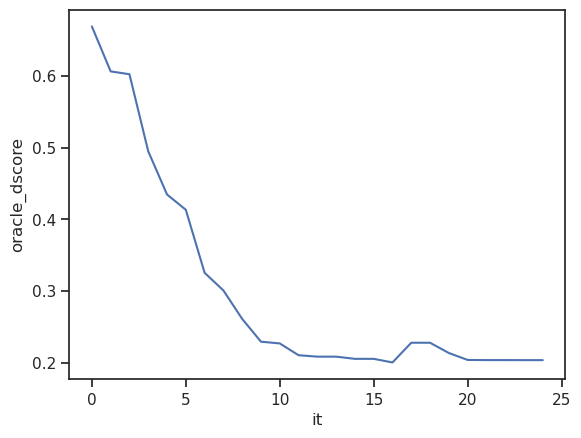

In [66]:
f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

ax = sns.lineplot(data=data, x='it', y='oracle_dscore', ax=ax, errorbar=None)

## Add cumulative time


In [67]:
cumulative_time = rs_df.groupby(['fps', 'highquality', 'rep'])[
    'duration_system'].cumsum().rename(
    'cumulative_time')
mff_sols_df = sols_df.join(cumulative_time)
# sols_df.info()

In [68]:
def average_sols_df(sols_df):
    return sols_df[['oracle_dscore', 'cumulative_time', 'solution_score']].groupby(
        ['fps', 'highquality', 'it']).mean()

<Axes: xlabel='cumulative_time', ylabel='oracle_dscore'>

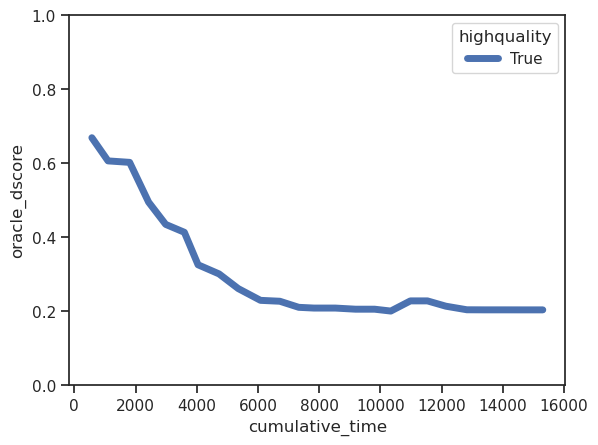

In [69]:
f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)
ax.set_ylim(0, 1)

sns.lineplot(data=average_sols_df(mff_sols_df).xs(("10", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
             y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)

In [70]:
def process_rs_df(rs_df):
    rs_df = rs_df.reset_index().set_index(
        ['fps', 'highquality', 'rep', 'it', 'route_id'])

    # get solutions at each iterations
    sols_df = get_rs_solutions(rs_df)

    # calculate cumulative time of iterations
    cumulative_time = (rs_df
                       .groupby(['fps', 'highquality', 'rep'])['duration_system']
                       .cumsum()
                       .rename('cumulative_time')
                       .to_frame()
                       .droplevel('route_id'))

    sols_df = sols_df.join(cumulative_time)

    return sols_df

In [71]:
old_rs = load_rs_df(RS_PATH)
old_sols_df = process_rs_df(old_rs)

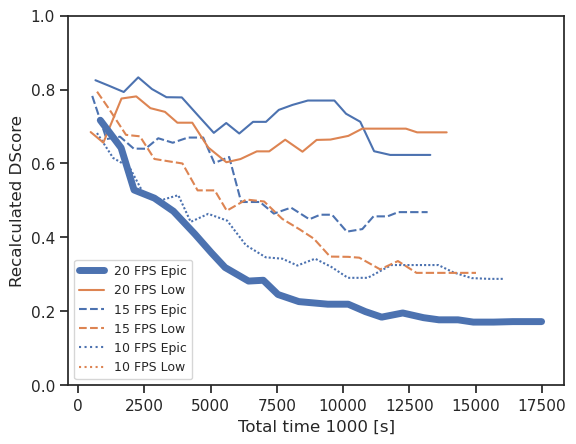

In [72]:
def plot_solutions(sols_df):
    sns.set_theme(style="ticks", palette="deep")

    f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

    sns.lineplot(data=average_sols_df(sols_df), x='cumulative_time', y='oracle_dscore',
                 style='fps', hue='highquality', ax=ax, errorbar=None)

    sns.lineplot(data=average_sols_df(sols_df).xs(("20", "True"), level=['fps', 'highquality'], drop_level=False),  x='cumulative_time',
                 y='oracle_dscore', hue='highquality', ax=ax,  errorbar=None, lw=5)

    ax.set_ylabel("Recalculated DScore")
    ax.set_xlabel("Total time 1000 [s]")
    ax.set_ylim(0, 1)

    # BETTER LEGEND
    handles, labels = ax.get_legend_handles_labels()

    blue = handles[1].get_color()
    orange = handles[2].get_color()
    lines = [
        mlines.Line2D([], [], color=blue, linestyle=None,
                      label='20 FPS Epic', lw=5),
        mlines.Line2D([], [], color=orange,
                      linestyle=None, label='20 FPS Low'),

        mlines.Line2D([], [], color=blue, linestyle='--', label='15 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='--', label='15 FPS Low'),
        mlines.Line2D([], [], color=blue, linestyle='dotted',
                      label='10 FPS Epic'),
        mlines.Line2D([], [], color=orange,
                      linestyle='dotted', label='10 FPS Low'),

    ]

    ax.legend(handles=lines, prop={'size': 9})

    # f.savefig('plot_rq3.pdf', bbox_inches='tight')


plot_solutions(process_rs_df(old_rs))

# PLOT


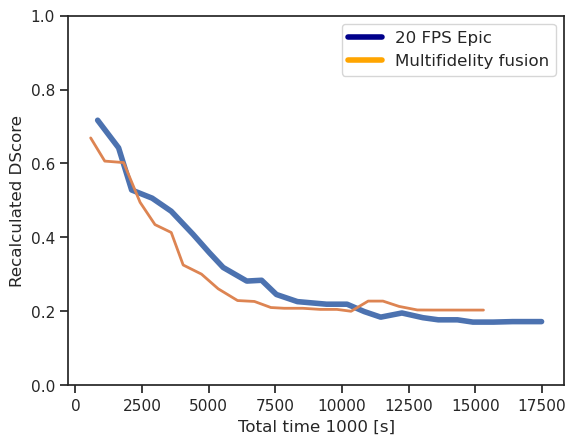

In [73]:

sns.set_theme(style="ticks", palette="deep")

f, ax = plt.subplots(nrows=1, sharex=True, sharey=True)

# sns.lineplot(data=average_sols_df(old_sols_df),  x='cumulative_time',
#              y='oracle_dscore', style='fps',  hue='highquality', ax=ax,  errorbar=None)

sns.lineplot(data=average_sols_df(old_sols_df).xs(("20", "True")),  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=4)

sns.lineplot(data=average_sols_df(mff_sols_df).xs(("10", "True"), drop_level=False),  x='cumulative_time',
             y='oracle_dscore', ax=ax,  errorbar=None, lw=2)


ax.set_ylabel("Recalculated DScore")
ax.set_xlabel("Total time 1000 [s]")
ax.set_ylim(0, 1)

lines = [
    mlines.Line2D([], [], color="darkblue", lw=4,
                  label='20 FPS Epic'),
    mlines.Line2D([], [], color="orange", lw=4,

                  label='Multifidelity fusion'),
]
ax.legend(handles=lines, prop={'size': 12})
f.savefig('plot.pdf', bbox_inches='tight')

## Statistical tests


In [74]:
from scipy.stats import mannwhitneyu
from itertools import permutations

In [75]:
mff_list = mff_sols_df['oracle_dscore'].groupby('it').agg(list)
high_fid_list = old_sols_df.xs(("20", "True"))[
    'oracle_dscore'].groupby('it').agg(list)

In [76]:
def do_test(fid_a, fid_b, set_a, set_b, confidence_level=0.95):
    U1, p = mannwhitneyu(set_a, set_b)

    max_error = 1 - confidence_level

    if p < max_error:
        print(
            f"\tAt the difference beetween {fid_a} and {fid_b} IS statistically significant. {p=:.5f}")
        print(set_a)
        print(set_b)
    else:
        # return
        print(
            f"\tAt the difference beetween {fid_a} and {fid_b} is NOT statistically significant. {p=:.5f}")

In [77]:
# # iterate over all possible fidelities
# ITERATION = 0
# a = old_sols_df.xs(("20", "True"))
# b = sols_df.xs(("10", "True"))
# for x in b.itertuples():
#     print(x)

In [78]:
for mf, hf in zip(mff_list, high_fid_list):
    do_test("MFF", "High fid", mf, hf)

	At the difference beetween MFF and High fid is NOT statistically significant. p=0.94466
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.88617
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.39143
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.67186
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.34204
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.52389
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.26713
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.45960
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.25172
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.12584
	At the difference beetween MFF and High fid is NOT statistically significant. p=0.26102
	At the difference be